# News Recommendation Based on Text Content

This dataset contains around 200k news headlines from the year 2012 to 2018 obtained from HuffPost. The dataset used can be found [here](https://www.kaggle.com/rmisra/news-category-dataset)

In [197]:
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import plotly.express as px

import re
import emoji
import spacy
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [59]:
data = []
with open('../news dataset/News_Category_Dataset_v2.json') as files:
    for file in files:
        data.append(json.loads(file))

df = pd.DataFrame(data)
df.head()

category                                           headline  \
0          CRIME  There Were 2 Mass Shootings In Texas Last Week...   
1  ENTERTAINMENT  Will Smith Joins Diplo And Nicky Jam For The 2...   
2  ENTERTAINMENT    Hugh Grant Marries For The First Time At Age 57   
3  ENTERTAINMENT  Jim Carrey Blasts 'Castrato' Adam Schiff And D...   
4  ENTERTAINMENT  Julianna Margulies Uses Donald Trump Poop Bags...   

           authors                                               link  \
0  Melissa Jeltsen  https://www.huffingtonpost.com/entry/texas-ama...   
1    Andy McDonald  https://www.huffingtonpost.com/entry/will-smit...   
2       Ron Dicker  https://www.huffingtonpost.com/entry/hugh-gran...   
3       Ron Dicker  https://www.huffingtonpost.com/entry/jim-carre...   
4       Ron Dicker  https://www.huffingtonpost.com/entry/julianna-...   

                                   short_description        date  
0  She left her husband. He killed their children...  2018-05-26  
1                           Of course it has a song.  2018-05-26  
2  The actor and his longtime girlfriend Anna Ebe...  2018-05-26  
3  The actor gives Dems an ass-kicking for not fi...  2018-05-26  
4  The "Dietland" actress said using the bags is ...  2018-05-26

In [26]:
count_freq = df.groupby('category').size().reset_index(name='counts').sort_values(by='counts')

# Data Exploration

<BarContainer object of 41 artists>

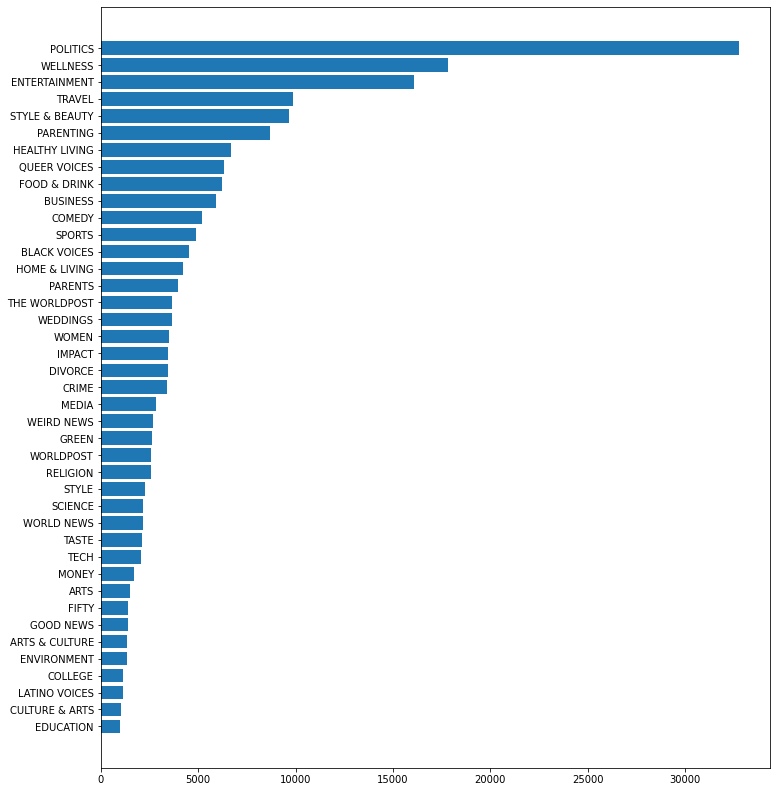

In [30]:
from matplotlib.pyplot import figure

figure(figsize=(12,14))
plt.barh(count_freq.category, count_freq.counts)

In [34]:
ts_df_news = df.groupby(['category', 'date']).size().reset_index(name='counts')

In [56]:
ts_df_news.head()

category        date  counts
0     ARTS  2014-04-18       3
1     ARTS  2014-04-19       4
2     ARTS  2014-04-20       3
3     ARTS  2014-04-21       5
4     ARTS  2014-04-22       8

In [53]:
ts_df_news_pivot = ts_df_news.pivot_table(index='date', columns='category',values='counts', aggfunc='sum') \
                    .fillna(0) \
                    .reset_index()

In [54]:
ts_df_news_pivot.head()

category        date  ARTS  ARTS & CULTURE  BLACK VOICES  BUSINESS  COLLEGE  \
0         2012-01-28   0.0             0.0           0.0       5.0      0.0   
1         2012-01-29   0.0             0.0           9.0       7.0      0.0   
2         2012-01-30   0.0             0.0           0.0       0.0      0.0   
3         2012-01-31   0.0             0.0           0.0       0.0      0.0   
4         2012-02-01   0.0             0.0           0.0       0.0      0.0   

category  COMEDY  CRIME  CULTURE & ARTS  DIVORCE  ...  TASTE  TECH  \
0            7.0    0.0             3.0      0.0  ...    0.0   6.0   
1            4.0    0.0             0.0      0.0  ...    0.0   4.0   
2            0.0    0.0             0.0      6.0  ...    0.0   0.0   
3            0.0    0.0             0.0      7.0  ...    0.0   0.0   
4            0.0    0.0             0.0      7.0  ...    0.0   0.0   

category  THE WORLDPOST  TRAVEL  WEDDINGS  WEIRD NEWS  WELLNESS  WOMEN  \
0                   0.0     1.0       0.0         0.0       7.0    0.0   
1                   0.0     2.0       1.0         0.0       5.0    0.0   
2                   0.0    24.0       5.0         0.0      21.0    0.0   
3                   0.0    10.0       9.0         0.0      18.0    0.0   
4                   0.0    13.0       6.0         0.0      24.0    0.0   

category  WORLD NEWS  WORLDPOST  
0                0.0        0.0  
1                0.0        0.0  
2                0.0        0.0  
3                0.0        0.0  
4                0.0        0.0  

[5 rows x 42 columns]

In [57]:
fig = px.line(ts_df_news_pivot, x="date", y=ts_df_news_pivot.columns,
              hover_data={"date": "|%B %d, %Y"},
              title='News published over time')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

In [185]:
# To simplify the problem, we will use only some categories to model. 
topics = ['POLITICS', 'TRAVEL', 'CRIME', 'SPORTS']
df_to_model = df[['category', 'headline', 'short_description']][df.category.isin(topics)]\
            .sample(3000) \
            .reset_index()

In [186]:
df_to_model

index  category                                           headline  \
0      92193    TRAVEL   Why Touristy Riviera Maya Is a Must-See Paradise   
1      37799  POLITICS  Lindsey Graham Chastises Republicans Happy Abo...   
2      12415  POLITICS  White House Lawyer Represented Arrested Saudi ...   
3     141318    TRAVEL             Put Some Tongue In It // Lingua Franca   
4      75231  POLITICS            Obama Finally Has His Own Facebook Page   
...      ...       ...                                                ...   
2995   11410  POLITICS  Lobbyists Swarm Congress To Protect Interests ...   
2996  115209  POLITICS                                 Jim Brady, My Hero   
2997   30258  POLITICS  John McCain: Devin Nunes 'Killed' Bipartisan R...   
2998   95462  POLITICS                                       Syrian Jihad   
2999   59209  POLITICS  GOP Senator Looks Forward To Donald Trump Appo...   

                                      short_description  
0     There's a good reason -- or rather, many wonde...  
1     "When one party is compromised, all of us are ...  
2     The Saudi government is holding Ty Cobb's old ...  
3     We all know and bemoan "touristy" when we see ...  
4     Obama used his first post to talk about climat...  
...                                                 ...  
2995  No legislation sweeps across American interest...  
2996  I first met Jim Brady when he was recruited to...  
2997  "Working together" is necessary for the securi...  
2998                                       Syrian Jihad  
2999                    Not one, not two ... but three.  

[3000 rows x 4 columns]

# Modeling

- *Token*: a unit of the text, it can be a word, a phrase, etc.
- *Document*: a sequence of tokens, for example a book or an article
- *Corpus*: a set of documents.
- *Matrix of document terms*: a matrix that students the frequency of terms in a corpus
- *Irrelevant Words*: Words that contain no information, which occur very often.

Defining a function that processes the text and returns the text tokenized and without stopwords, emoji, punctuation and numbers, etc:

In [124]:
def preprocess_text(text, remove_stop = True, stem_words = False, remove_mentions_hashtags = True):
    """
    eg:
    input: preprocess_text("@water #dream hi hello where are you going be there tomorrow happening happen happens",  
    stem_words = True) 
    output: ['tomorrow', 'happen', 'go', 'hello']
    """

    # Remove emojis
    emoji_pattern = re.compile("[" "\U0001F1E0-\U0001F6FF" "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r"", text)
    text = "".join([x for x in text if x not in emoji.UNICODE_EMOJI])

    if remove_mentions_hashtags:
        text = re.sub(r"@(\w+)", " ", text)
        text = re.sub(r"#(\w+)", " ", text)

    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    words = (''.join(nopunct)).split()

    if(remove_stop):
        words = [w for w in words if w not in ENGLISH_STOP_WORDS]
        words = [w for w in words if len(w) > 2]  # remove a,an,of etc.

    if(stem_words):
        stemmer = PorterStemmer()
        words = [stemmer.stem(w) for w in words]

    return ' '.join(words)

In [187]:
rows, cols = df_to_model.shape

In [188]:
df_to_model['token'] = [preprocess_text(df_to_model["headline"][row]) for row in range(rows)]

In [189]:
df_to_model.head()

index  category                                           headline  \
0   92193    TRAVEL   Why Touristy Riviera Maya Is a Must-See Paradise   
1   37799  POLITICS  Lindsey Graham Chastises Republicans Happy Abo...   
2   12415  POLITICS  White House Lawyer Represented Arrested Saudi ...   
3  141318    TRAVEL             Put Some Tongue In It // Lingua Franca   
4   75231  POLITICS            Obama Finally Has His Own Facebook Page   

                                   short_description  \
0  There's a good reason -- or rather, many wonde...   
1  "When one party is compromised, all of us are ...   
2  The Saudi government is holding Ty Cobb's old ...   
3  We all know and bemoan "touristy" when we see ...   
4  Obama used his first post to talk about climat...   

                                               token  
0                     touristy riviera maya paradise  
1  lindsey graham chastises republicans happy hac...  
2  white house lawyer represented arrested saudi ...  
3                               tongue lingua franca  
4                        obama finally facebook page

# Word Embedding

# Important Doc
https://spacy.io/usage

In [88]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 45.7 MB 837 kB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [89]:
nlp = spacy.load('en_core_web_md')

# Vectoring each word.
Here, as each document has a different number of words, we will have matrices with different dimensions. Our ultimate goal is to be able to represent each document as a vector that summarizes the document. That is, we want to represent different matrices as vectors. There are several ways to do this (vector average, TF-IDF weighted average), but in this test we will do a simple average.

In [144]:
def vec(document):
    return nlp(document).vector

In [190]:
vec_size = 300
final_feature_matrix = np.empty([rows, vec_size])

for row, document in enumerate(df_to_model['token']):
    final_feature_matrix[row,:] = vec(document)

## Subject clustering:

Now that we have a vector that represents each document, let's use some clustering method to try to retrieve the selected editorials at the beginning. Let's run a k-means on each vector that represents a document and (as it's a test) ask for 4 clusters for it.

In [177]:
final_feature_matrix

array([[ 0.24478   , -0.08067405, -0.25994116, ..., -0.17101724,
         0.01397425,  0.25461873],
       [-0.16591901,  0.1893615 ,  0.02411832, ...,  0.0462915 ,
         0.04749683,  0.04169217],
       [-0.18225425,  0.020688  ,  0.1123    , ...,  0.04759525,
        -0.12046999, -0.01293001],
       ...,
       [ 0.12263384, -0.03147334,  0.13631433, ..., -0.21503119,
         0.03590201,  0.25790149],
       [-0.05926716, -0.275543  ,  0.17868733, ...,  0.01659834,
         0.06864934, -0.38709998],
       [-0.03265323,  0.02126723, -0.00232994, ...,  0.12401088,
         0.02161467,  0.15941922]])

In [191]:
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=4, random_state=0).fit(final_feature_matrix)
kmeans.labels_

array([3, 2, 1, ..., 2, 0, 0], dtype=int32)

In [192]:
print(df_to_model["category"][kmeans.labels_ == 0]) 
print(df_to_model["category"][kmeans.labels_ == 1])
print(df_to_model["category"][kmeans.labels_ == 2])
print(df_to_model["category"][kmeans.labels_ == 3])

5       POLITICS
7       POLITICS
13      POLITICS
14      POLITICS
15      POLITICS
          ...   
2989    POLITICS
2991    POLITICS
2995    POLITICS
2998    POLITICS
2999    POLITICS
Name: category, Length: 950, dtype: object
2       POLITICS
3         TRAVEL
9          CRIME
10      POLITICS
12         CRIME
          ...   
2979    POLITICS
2980      TRAVEL
2982      SPORTS
2983       CRIME
2984       CRIME
Name: category, Length: 873, dtype: object
1       POLITICS
4       POLITICS
8         TRAVEL
11      POLITICS
17      POLITICS
          ...   
2987    POLITICS
2990    POLITICS
2993    POLITICS
2996    POLITICS
2997    POLITICS
Name: category, Length: 755, dtype: object
0       TRAVEL
6       TRAVEL
48      TRAVEL
69      TRAVEL
71      TRAVEL
         ...  
2969    TRAVEL
2973    TRAVEL
2986    TRAVEL
2992    TRAVEL
2994    TRAVEL
Name: category, Length: 422, dtype: object


# Visualizing  the results

As we are dealing with a high dimension (300) for each document, we cannot clearly see what we are clustering. A simple method to explore the results obtained is to reduce the problem dimension to 2, 3 and make exploratory graphs that allow visualizing the data.

In [193]:
import numpy as np
from sklearn.manifold import TSNE
X = final_feature_matrix.astype(float)
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)
X_embedded.shape

(3000, 2)

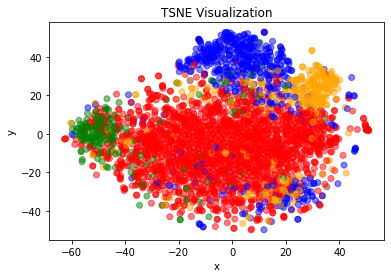

In [194]:
# Create data

x = X_embedded[:,0]
y = X_embedded[:,1]

# Plot

colors = {'POLITICS':'red', 'TRAVEL':'blue', 'CRIME':'green', 'SPORTS': 'orange'}
plt.scatter(x, y, alpha=0.5, c = df_to_model['category'].apply(lambda x: colors[x]))
plt.title('TSNE Visualization')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Making Recommendations

In [209]:
def make_recommendation(articles_vecs, article_position, df):
    article_vec = articles_vecs[article_position, :]
    other_vec = np.delete(articles_vecs, article_position, 0)
    
    A = [other_vec[row,:] for row in range(other_vec.shape[0])]
    tree = spatial.KDTree(A)
    closest_position = tree.query(article_vec)[1]
    
    print('User Article')
    print(df.at[article_position])
    
    print('Recommended Article')
    print(df.at[closest_position])
    return tree.query(article_vec)[0], closest_position

In [220]:
make_recommendation(final_feature_matrix, 2981, df_to_model['headline'])

User Article
Donald Trump Is Now Calling Obama The 'Most Valuable Player' For ISIS
Recommended Article
Mike Pence, Like Donald Trump, Thinks Putin Is 'A Stronger Leader' Than Obama


(2.079749018611765, 1353)